# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

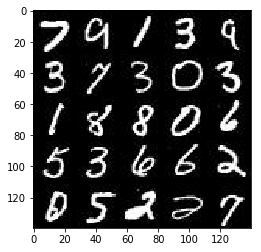

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

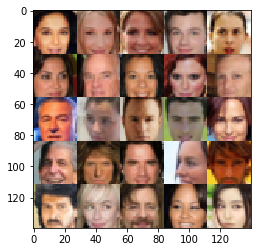

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, shape=(None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, shape=(None), name='learning_rate')
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        l1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * l1, l1)
        
        l2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(l2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        l3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(l3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):

        l1 = tf.layers.dense(z, 4*4*512)
        l1 = tf.reshape(l1, (-1, 4, 4, 512))
        l1 = tf.layers.batch_normalization(l1, training=is_train)
        l1 = tf.maximum(alpha * l1, l1)
        # 4x4x512 now
        
        l2 = tf.layers.conv2d_transpose(l1, 256, 4, strides=1, padding='valid')
        l2 = tf.layers.batch_normalization(l2, training=is_train)
        l2 = tf.maximum(alpha * l2, l2)
        # 7x7x256 now
        
        l3 = tf.layers.conv2d_transpose(l2, 128, 5, strides=2, padding='same')
        l3 = tf.layers.batch_normalization(l3, training=is_train)
        l3 = tf.maximum(alpha * l3, l3)
        # 14x14x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(l3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    total_data_size, image_width, image_height, image_channels = data_shape

    input_real, input_z, learning_rate_input = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)

    steps = 0
    print_every = 10
    show_every = 100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1

                # Generate random noise
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, 
                                               learning_rate_input: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images,
                                               learning_rate_input: learning_rate})
                # My first submission didn't generate good pictures because after about 60-70 batches the
                # discriminator's loss would get very small, and the generator's loss would start increasing.
                # I suspect what happened is the discriminator got "too good" and the generator was no longer
                # able to learn what would pass for a real image so it couldn't learn further. I added these extra runs
                # so the generator would be able to learn as quickly and compete better with the discriminator.
                # The generator loss became much more stable, and the you can now see the losses alternating as
                # the discriminator and generator compete to make each other better, particularly on the mnist data.
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images,
                                               learning_rate_input: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images,
                                               learning_rate_input: learning_rate})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{} Batch Step {}...".format(epoch_i, epoch_count, steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % show_every == 0:
                    show_generator_output(sess, 20, input_z, image_channels, data_image_mode)
                
        print('Done Training!')
        show_generator_output(sess, 20, input_z, image_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 0/2 Batch Step 10... Discriminator Loss: 3.9236... Generator Loss: 0.0598
Epoch 0/2 Batch Step 20... Discriminator Loss: 4.5058... Generator Loss: 0.1582
Epoch 0/2 Batch Step 30... Discriminator Loss: 2.6230... Generator Loss: 0.2651
Epoch 0/2 Batch Step 40... Discriminator Loss: 1.7832... Generator Loss: 0.3307
Epoch 0/2 Batch Step 50... Discriminator Loss: 2.4051... Generator Loss: 0.2955
Epoch 0/2 Batch Step 60... Discriminator Loss: 1.5175... Generator Loss: 0.5759
Epoch 0/2 Batch Step 70... Discriminator Loss: 1.3903... Generator Loss: 0.6199
Epoch 0/2 Batch Step 80... Discriminator Loss: 1.7724... Generator Loss: 0.4744
Epoch 0/2 Batch Step 90... Discriminator Loss: 1.5205... Generator Loss: 0.4985
Epoch 0/2 Batch Step 100... Discriminator Loss: 1.7608... Generator Loss: 0.4110


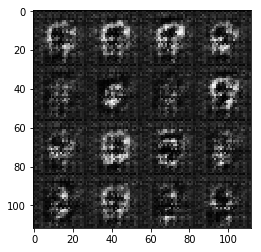

Epoch 0/2 Batch Step 110... Discriminator Loss: 2.0304... Generator Loss: 0.3480
Epoch 0/2 Batch Step 120... Discriminator Loss: 2.7677... Generator Loss: 0.0920
Epoch 0/2 Batch Step 130... Discriminator Loss: 2.0834... Generator Loss: 0.4292
Epoch 0/2 Batch Step 140... Discriminator Loss: 1.5556... Generator Loss: 0.5230
Epoch 0/2 Batch Step 150... Discriminator Loss: 1.5575... Generator Loss: 0.6444
Epoch 0/2 Batch Step 160... Discriminator Loss: 1.3841... Generator Loss: 0.6367
Epoch 0/2 Batch Step 170... Discriminator Loss: 1.4178... Generator Loss: 0.6996
Epoch 0/2 Batch Step 180... Discriminator Loss: 1.4168... Generator Loss: 0.5573
Epoch 0/2 Batch Step 190... Discriminator Loss: 1.3343... Generator Loss: 0.5553
Epoch 0/2 Batch Step 200... Discriminator Loss: 1.3529... Generator Loss: 1.0900


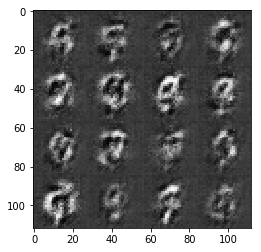

Epoch 0/2 Batch Step 210... Discriminator Loss: 1.5008... Generator Loss: 0.4873
Epoch 0/2 Batch Step 220... Discriminator Loss: 1.4758... Generator Loss: 0.4627
Epoch 0/2 Batch Step 230... Discriminator Loss: 1.3653... Generator Loss: 0.9136
Epoch 0/2 Batch Step 240... Discriminator Loss: 1.2662... Generator Loss: 0.9235
Epoch 0/2 Batch Step 250... Discriminator Loss: 1.4367... Generator Loss: 0.4761
Epoch 0/2 Batch Step 260... Discriminator Loss: 1.3796... Generator Loss: 0.5108
Epoch 0/2 Batch Step 270... Discriminator Loss: 1.2473... Generator Loss: 1.2655
Epoch 0/2 Batch Step 280... Discriminator Loss: 1.4120... Generator Loss: 0.8465
Epoch 0/2 Batch Step 290... Discriminator Loss: 1.4637... Generator Loss: 0.3836
Epoch 0/2 Batch Step 300... Discriminator Loss: 1.3119... Generator Loss: 0.7563


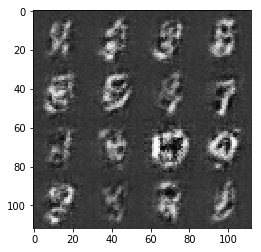

Epoch 0/2 Batch Step 310... Discriminator Loss: 1.1885... Generator Loss: 0.8746
Epoch 0/2 Batch Step 320... Discriminator Loss: 1.3702... Generator Loss: 0.5049
Epoch 0/2 Batch Step 330... Discriminator Loss: 1.2452... Generator Loss: 0.9231
Epoch 0/2 Batch Step 340... Discriminator Loss: 1.2983... Generator Loss: 0.5526
Epoch 0/2 Batch Step 350... Discriminator Loss: 1.2350... Generator Loss: 0.6693
Epoch 0/2 Batch Step 360... Discriminator Loss: 1.1205... Generator Loss: 0.8566
Epoch 0/2 Batch Step 370... Discriminator Loss: 1.2404... Generator Loss: 0.9993
Epoch 0/2 Batch Step 380... Discriminator Loss: 1.4247... Generator Loss: 0.4571
Epoch 0/2 Batch Step 390... Discriminator Loss: 1.4574... Generator Loss: 0.4013
Epoch 0/2 Batch Step 400... Discriminator Loss: 1.7692... Generator Loss: 0.2296


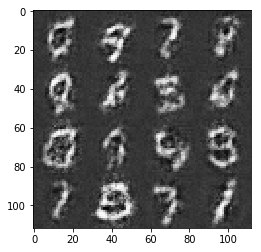

Epoch 0/2 Batch Step 410... Discriminator Loss: 1.3172... Generator Loss: 0.4124
Epoch 0/2 Batch Step 420... Discriminator Loss: 0.8800... Generator Loss: 1.1116
Epoch 0/2 Batch Step 430... Discriminator Loss: 1.5760... Generator Loss: 0.2982
Epoch 0/2 Batch Step 440... Discriminator Loss: 0.8108... Generator Loss: 1.6178
Epoch 0/2 Batch Step 450... Discriminator Loss: 1.5216... Generator Loss: 0.2856
Epoch 0/2 Batch Step 460... Discriminator Loss: 1.4728... Generator Loss: 0.3443
Epoch 0/2 Batch Step 470... Discriminator Loss: 0.9939... Generator Loss: 0.6755
Epoch 0/2 Batch Step 480... Discriminator Loss: 0.9244... Generator Loss: 0.7535
Epoch 0/2 Batch Step 490... Discriminator Loss: 1.9447... Generator Loss: 0.1818
Epoch 0/2 Batch Step 500... Discriminator Loss: 0.7657... Generator Loss: 1.1738


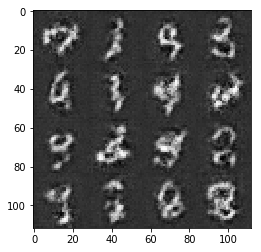

Epoch 0/2 Batch Step 510... Discriminator Loss: 1.0251... Generator Loss: 0.6203
Epoch 0/2 Batch Step 520... Discriminator Loss: 1.1463... Generator Loss: 0.5075
Epoch 0/2 Batch Step 530... Discriminator Loss: 1.6870... Generator Loss: 0.5044
Epoch 0/2 Batch Step 540... Discriminator Loss: 1.5227... Generator Loss: 0.3055
Epoch 0/2 Batch Step 550... Discriminator Loss: 1.7973... Generator Loss: 0.2173
Epoch 0/2 Batch Step 560... Discriminator Loss: 1.3483... Generator Loss: 0.3939
Epoch 0/2 Batch Step 570... Discriminator Loss: 1.0912... Generator Loss: 0.5405
Epoch 0/2 Batch Step 580... Discriminator Loss: 1.3180... Generator Loss: 0.3719
Epoch 0/2 Batch Step 590... Discriminator Loss: 2.7379... Generator Loss: 0.0885
Epoch 0/2 Batch Step 600... Discriminator Loss: 1.0534... Generator Loss: 0.6269


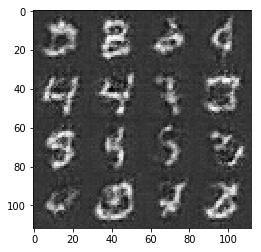

Epoch 0/2 Batch Step 610... Discriminator Loss: 1.4092... Generator Loss: 0.3316
Epoch 0/2 Batch Step 620... Discriminator Loss: 1.3248... Generator Loss: 1.0131
Epoch 0/2 Batch Step 630... Discriminator Loss: 1.3847... Generator Loss: 0.3598
Epoch 0/2 Batch Step 640... Discriminator Loss: 0.3772... Generator Loss: 2.0646
Epoch 0/2 Batch Step 650... Discriminator Loss: 0.3094... Generator Loss: 2.3711
Epoch 0/2 Batch Step 660... Discriminator Loss: 2.9192... Generator Loss: 0.0612
Epoch 0/2 Batch Step 670... Discriminator Loss: 1.4712... Generator Loss: 0.3339
Epoch 0/2 Batch Step 680... Discriminator Loss: 1.0514... Generator Loss: 0.6721
Epoch 0/2 Batch Step 690... Discriminator Loss: 1.8267... Generator Loss: 0.2028
Epoch 0/2 Batch Step 700... Discriminator Loss: 1.0111... Generator Loss: 0.5553


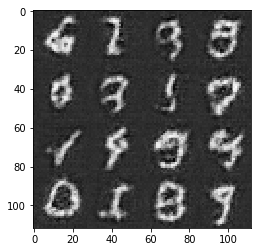

Epoch 0/2 Batch Step 710... Discriminator Loss: 1.4302... Generator Loss: 0.3471
Epoch 0/2 Batch Step 720... Discriminator Loss: 2.4974... Generator Loss: 0.1135
Epoch 0/2 Batch Step 730... Discriminator Loss: 1.5424... Generator Loss: 0.3161
Epoch 0/2 Batch Step 740... Discriminator Loss: 1.6784... Generator Loss: 0.2605
Epoch 0/2 Batch Step 750... Discriminator Loss: 1.4492... Generator Loss: 0.3163
Epoch 0/2 Batch Step 760... Discriminator Loss: 1.0399... Generator Loss: 2.0228
Epoch 0/2 Batch Step 770... Discriminator Loss: 1.3617... Generator Loss: 0.4083
Epoch 0/2 Batch Step 780... Discriminator Loss: 0.4900... Generator Loss: 1.6954
Epoch 0/2 Batch Step 790... Discriminator Loss: 1.4343... Generator Loss: 0.3296
Epoch 0/2 Batch Step 800... Discriminator Loss: 1.5641... Generator Loss: 0.2900


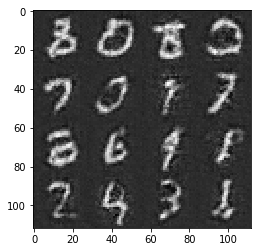

Epoch 0/2 Batch Step 810... Discriminator Loss: 0.7335... Generator Loss: 1.8131
Epoch 0/2 Batch Step 820... Discriminator Loss: 0.5793... Generator Loss: 1.0420
Epoch 0/2 Batch Step 830... Discriminator Loss: 2.5905... Generator Loss: 6.0881
Epoch 0/2 Batch Step 840... Discriminator Loss: 1.0104... Generator Loss: 0.7928
Epoch 0/2 Batch Step 850... Discriminator Loss: 1.1952... Generator Loss: 0.5057
Epoch 0/2 Batch Step 860... Discriminator Loss: 1.5029... Generator Loss: 0.3052
Epoch 0/2 Batch Step 870... Discriminator Loss: 0.3777... Generator Loss: 1.5395
Epoch 0/2 Batch Step 880... Discriminator Loss: 0.2383... Generator Loss: 2.9183
Epoch 0/2 Batch Step 890... Discriminator Loss: 1.9987... Generator Loss: 0.1703
Epoch 0/2 Batch Step 900... Discriminator Loss: 1.8335... Generator Loss: 0.2539


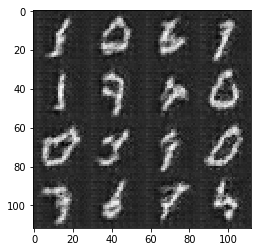

Epoch 0/2 Batch Step 910... Discriminator Loss: 0.7566... Generator Loss: 1.1581
Epoch 0/2 Batch Step 920... Discriminator Loss: 0.5011... Generator Loss: 1.6547
Epoch 0/2 Batch Step 930... Discriminator Loss: 1.1982... Generator Loss: 0.4338
Epoch 1/2 Batch Step 940... Discriminator Loss: 1.1684... Generator Loss: 0.4794
Epoch 1/2 Batch Step 950... Discriminator Loss: 1.5184... Generator Loss: 0.3209
Epoch 1/2 Batch Step 960... Discriminator Loss: 0.6675... Generator Loss: 1.1381
Epoch 1/2 Batch Step 970... Discriminator Loss: 0.4305... Generator Loss: 2.6644
Epoch 1/2 Batch Step 980... Discriminator Loss: 0.4198... Generator Loss: 1.3588
Epoch 1/2 Batch Step 990... Discriminator Loss: 0.4266... Generator Loss: 1.5242
Epoch 1/2 Batch Step 1000... Discriminator Loss: 1.4666... Generator Loss: 0.3196


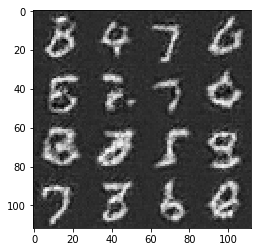

Epoch 1/2 Batch Step 1010... Discriminator Loss: 0.4303... Generator Loss: 1.6125
Epoch 1/2 Batch Step 1020... Discriminator Loss: 3.0976... Generator Loss: 0.0668
Epoch 1/2 Batch Step 1030... Discriminator Loss: 1.4527... Generator Loss: 0.3374
Epoch 1/2 Batch Step 1040... Discriminator Loss: 0.3566... Generator Loss: 2.9757
Epoch 1/2 Batch Step 1050... Discriminator Loss: 2.6406... Generator Loss: 0.0879
Epoch 1/2 Batch Step 1060... Discriminator Loss: 1.4421... Generator Loss: 0.3497
Epoch 1/2 Batch Step 1070... Discriminator Loss: 1.1429... Generator Loss: 0.4893
Epoch 1/2 Batch Step 1080... Discriminator Loss: 1.3370... Generator Loss: 0.3920
Epoch 1/2 Batch Step 1090... Discriminator Loss: 2.0321... Generator Loss: 0.1900
Epoch 1/2 Batch Step 1100... Discriminator Loss: 1.2704... Generator Loss: 0.4806


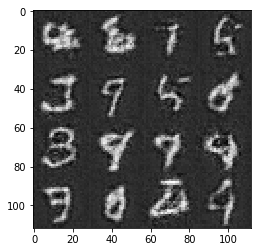

Epoch 1/2 Batch Step 1110... Discriminator Loss: 1.0543... Generator Loss: 0.5473
Epoch 1/2 Batch Step 1120... Discriminator Loss: 1.7447... Generator Loss: 0.2300
Epoch 1/2 Batch Step 1130... Discriminator Loss: 1.0388... Generator Loss: 0.6038
Epoch 1/2 Batch Step 1140... Discriminator Loss: 0.4060... Generator Loss: 2.6695
Epoch 1/2 Batch Step 1150... Discriminator Loss: 1.6089... Generator Loss: 0.2698
Epoch 1/2 Batch Step 1160... Discriminator Loss: 0.7800... Generator Loss: 0.8220
Epoch 1/2 Batch Step 1170... Discriminator Loss: 1.0176... Generator Loss: 0.8986
Epoch 1/2 Batch Step 1180... Discriminator Loss: 1.7973... Generator Loss: 0.6291
Epoch 1/2 Batch Step 1190... Discriminator Loss: 0.7816... Generator Loss: 1.0872
Epoch 1/2 Batch Step 1200... Discriminator Loss: 1.1712... Generator Loss: 0.4800


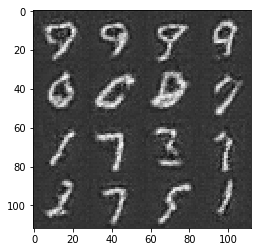

Epoch 1/2 Batch Step 1210... Discriminator Loss: 1.3645... Generator Loss: 0.3641
Epoch 1/2 Batch Step 1220... Discriminator Loss: 0.8152... Generator Loss: 0.7023
Epoch 1/2 Batch Step 1230... Discriminator Loss: 1.7522... Generator Loss: 0.2404
Epoch 1/2 Batch Step 1240... Discriminator Loss: 1.9715... Generator Loss: 0.2639
Epoch 1/2 Batch Step 1250... Discriminator Loss: 0.7049... Generator Loss: 0.9933
Epoch 1/2 Batch Step 1260... Discriminator Loss: 1.3960... Generator Loss: 0.3488
Epoch 1/2 Batch Step 1270... Discriminator Loss: 1.6212... Generator Loss: 0.2624
Epoch 1/2 Batch Step 1280... Discriminator Loss: 2.5819... Generator Loss: 0.1669
Epoch 1/2 Batch Step 1290... Discriminator Loss: 1.7753... Generator Loss: 0.2871
Epoch 1/2 Batch Step 1300... Discriminator Loss: 1.2926... Generator Loss: 0.5086


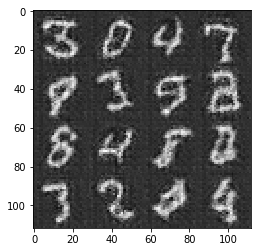

Epoch 1/2 Batch Step 1310... Discriminator Loss: 1.1519... Generator Loss: 0.7904
Epoch 1/2 Batch Step 1320... Discriminator Loss: 0.9971... Generator Loss: 0.6159
Epoch 1/2 Batch Step 1330... Discriminator Loss: 0.9668... Generator Loss: 0.6111
Epoch 1/2 Batch Step 1340... Discriminator Loss: 1.7920... Generator Loss: 6.6477
Epoch 1/2 Batch Step 1350... Discriminator Loss: 1.2825... Generator Loss: 0.3859
Epoch 1/2 Batch Step 1360... Discriminator Loss: 0.3114... Generator Loss: 2.8236
Epoch 1/2 Batch Step 1370... Discriminator Loss: 0.3163... Generator Loss: 1.8123
Epoch 1/2 Batch Step 1380... Discriminator Loss: 1.2569... Generator Loss: 0.4150
Epoch 1/2 Batch Step 1390... Discriminator Loss: 1.0187... Generator Loss: 0.5925
Epoch 1/2 Batch Step 1400... Discriminator Loss: 1.6469... Generator Loss: 0.2582


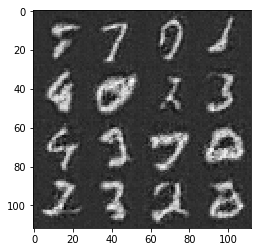

Epoch 1/2 Batch Step 1410... Discriminator Loss: 1.3383... Generator Loss: 1.8177
Epoch 1/2 Batch Step 1420... Discriminator Loss: 1.0757... Generator Loss: 0.9649
Epoch 1/2 Batch Step 1430... Discriminator Loss: 1.2207... Generator Loss: 0.7380
Epoch 1/2 Batch Step 1440... Discriminator Loss: 1.2794... Generator Loss: 0.5054
Epoch 1/2 Batch Step 1450... Discriminator Loss: 1.0490... Generator Loss: 0.7357
Epoch 1/2 Batch Step 1460... Discriminator Loss: 1.1988... Generator Loss: 0.4610
Epoch 1/2 Batch Step 1470... Discriminator Loss: 1.7752... Generator Loss: 0.2329
Epoch 1/2 Batch Step 1480... Discriminator Loss: 1.5900... Generator Loss: 0.3267
Epoch 1/2 Batch Step 1490... Discriminator Loss: 0.7878... Generator Loss: 1.2267
Epoch 1/2 Batch Step 1500... Discriminator Loss: 0.6594... Generator Loss: 4.0642


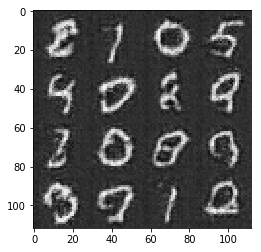

Epoch 1/2 Batch Step 1510... Discriminator Loss: 1.1812... Generator Loss: 0.5751
Epoch 1/2 Batch Step 1520... Discriminator Loss: 0.9779... Generator Loss: 0.6870
Epoch 1/2 Batch Step 1530... Discriminator Loss: 1.0338... Generator Loss: 0.5281
Epoch 1/2 Batch Step 1540... Discriminator Loss: 0.7684... Generator Loss: 0.8704
Epoch 1/2 Batch Step 1550... Discriminator Loss: 1.5177... Generator Loss: 0.8888
Epoch 1/2 Batch Step 1560... Discriminator Loss: 0.7476... Generator Loss: 1.1738
Epoch 1/2 Batch Step 1570... Discriminator Loss: 1.9031... Generator Loss: 0.1987
Epoch 1/2 Batch Step 1580... Discriminator Loss: 1.1153... Generator Loss: 0.5250
Epoch 1/2 Batch Step 1590... Discriminator Loss: 0.7167... Generator Loss: 0.9623
Epoch 1/2 Batch Step 1600... Discriminator Loss: 1.1455... Generator Loss: 0.4849


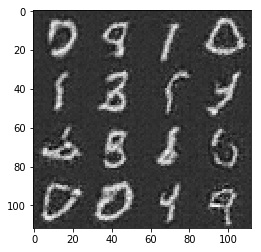

Epoch 1/2 Batch Step 1610... Discriminator Loss: 0.6011... Generator Loss: 0.9931
Epoch 1/2 Batch Step 1620... Discriminator Loss: 2.2695... Generator Loss: 0.1353
Epoch 1/2 Batch Step 1630... Discriminator Loss: 1.3501... Generator Loss: 0.3579
Epoch 1/2 Batch Step 1640... Discriminator Loss: 1.7403... Generator Loss: 0.2671
Epoch 1/2 Batch Step 1650... Discriminator Loss: 0.0875... Generator Loss: 3.5023
Epoch 1/2 Batch Step 1660... Discriminator Loss: 1.1775... Generator Loss: 0.4630
Epoch 1/2 Batch Step 1670... Discriminator Loss: 2.9003... Generator Loss: 0.0705
Epoch 1/2 Batch Step 1680... Discriminator Loss: 0.3681... Generator Loss: 2.7125
Epoch 1/2 Batch Step 1690... Discriminator Loss: 1.4140... Generator Loss: 0.3277
Epoch 1/2 Batch Step 1700... Discriminator Loss: 0.5318... Generator Loss: 1.0545


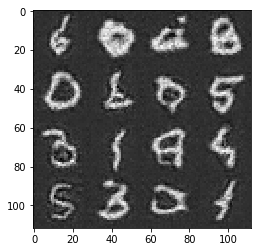

Epoch 1/2 Batch Step 1710... Discriminator Loss: 1.5934... Generator Loss: 2.8778
Epoch 1/2 Batch Step 1720... Discriminator Loss: 0.8872... Generator Loss: 0.7935
Epoch 1/2 Batch Step 1730... Discriminator Loss: 1.2867... Generator Loss: 0.4227
Epoch 1/2 Batch Step 1740... Discriminator Loss: 1.1594... Generator Loss: 0.5165
Epoch 1/2 Batch Step 1750... Discriminator Loss: 1.3926... Generator Loss: 0.3563
Epoch 1/2 Batch Step 1760... Discriminator Loss: 0.9617... Generator Loss: 0.6227
Epoch 1/2 Batch Step 1770... Discriminator Loss: 1.1801... Generator Loss: 0.4907
Epoch 1/2 Batch Step 1780... Discriminator Loss: 0.6017... Generator Loss: 1.0276
Epoch 1/2 Batch Step 1790... Discriminator Loss: 2.0045... Generator Loss: 0.1810
Epoch 1/2 Batch Step 1800... Discriminator Loss: 1.6804... Generator Loss: 0.2784


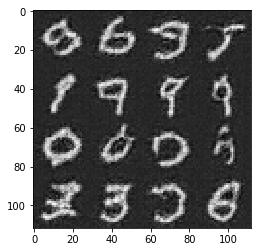

Epoch 1/2 Batch Step 1810... Discriminator Loss: 1.1319... Generator Loss: 0.4775
Epoch 1/2 Batch Step 1820... Discriminator Loss: 1.6619... Generator Loss: 0.3183
Epoch 1/2 Batch Step 1830... Discriminator Loss: 0.8760... Generator Loss: 1.1078
Epoch 1/2 Batch Step 1840... Discriminator Loss: 1.0965... Generator Loss: 0.4977
Epoch 1/2 Batch Step 1850... Discriminator Loss: 0.6559... Generator Loss: 2.5487
Epoch 1/2 Batch Step 1860... Discriminator Loss: 2.5044... Generator Loss: 0.1108
Epoch 1/2 Batch Step 1870... Discriminator Loss: 1.5264... Generator Loss: 0.3115
Done Training!


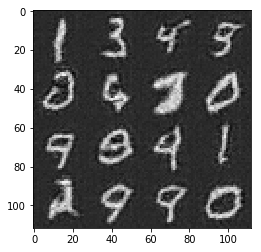

In [28]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 0/1 Batch Step 10... Discriminator Loss: 6.3088... Generator Loss: 0.0125
Epoch 0/1 Batch Step 20... Discriminator Loss: 4.4915... Generator Loss: 0.1073
Epoch 0/1 Batch Step 30... Discriminator Loss: 3.1596... Generator Loss: 0.2844
Epoch 0/1 Batch Step 40... Discriminator Loss: 2.4884... Generator Loss: 0.2787
Epoch 0/1 Batch Step 50... Discriminator Loss: 1.8048... Generator Loss: 0.5531
Epoch 0/1 Batch Step 60... Discriminator Loss: 1.6346... Generator Loss: 0.6407
Epoch 0/1 Batch Step 70... Discriminator Loss: 1.2515... Generator Loss: 0.8303
Epoch 0/1 Batch Step 80... Discriminator Loss: 0.9737... Generator Loss: 0.9127
Epoch 0/1 Batch Step 90... Discriminator Loss: 1.2388... Generator Loss: 0.7652
Epoch 0/1 Batch Step 100... Discriminator Loss: 1.5668... Generator Loss: 0.9026


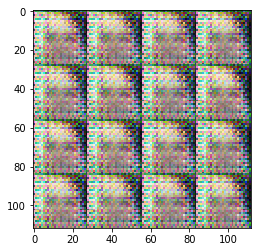

Epoch 0/1 Batch Step 110... Discriminator Loss: 0.7917... Generator Loss: 1.3052
Epoch 0/1 Batch Step 120... Discriminator Loss: 0.7206... Generator Loss: 1.4381
Epoch 0/1 Batch Step 130... Discriminator Loss: 1.7938... Generator Loss: 0.5141
Epoch 0/1 Batch Step 140... Discriminator Loss: 2.3127... Generator Loss: 0.2578
Epoch 0/1 Batch Step 150... Discriminator Loss: 1.2389... Generator Loss: 3.6541
Epoch 0/1 Batch Step 160... Discriminator Loss: 2.2272... Generator Loss: 0.3851
Epoch 0/1 Batch Step 170... Discriminator Loss: 3.0438... Generator Loss: 0.1666
Epoch 0/1 Batch Step 180... Discriminator Loss: 2.2124... Generator Loss: 0.4378
Epoch 0/1 Batch Step 190... Discriminator Loss: 1.9069... Generator Loss: 0.6623
Epoch 0/1 Batch Step 200... Discriminator Loss: 1.8598... Generator Loss: 0.4284


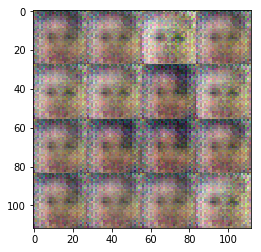

Epoch 0/1 Batch Step 210... Discriminator Loss: 1.7243... Generator Loss: 0.7003
Epoch 0/1 Batch Step 220... Discriminator Loss: 1.6714... Generator Loss: 0.6382
Epoch 0/1 Batch Step 230... Discriminator Loss: 1.6034... Generator Loss: 0.6809
Epoch 0/1 Batch Step 240... Discriminator Loss: 1.6323... Generator Loss: 0.5857
Epoch 0/1 Batch Step 250... Discriminator Loss: 1.5735... Generator Loss: 0.6166
Epoch 0/1 Batch Step 260... Discriminator Loss: 1.3349... Generator Loss: 0.6230
Epoch 0/1 Batch Step 270... Discriminator Loss: 1.5297... Generator Loss: 0.7797
Epoch 0/1 Batch Step 280... Discriminator Loss: 1.7753... Generator Loss: 0.5678
Epoch 0/1 Batch Step 290... Discriminator Loss: 1.6567... Generator Loss: 0.5807
Epoch 0/1 Batch Step 300... Discriminator Loss: 1.5855... Generator Loss: 0.6249


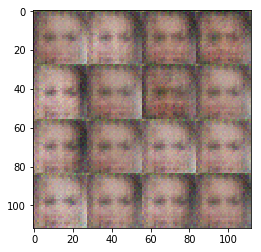

Epoch 0/1 Batch Step 310... Discriminator Loss: 1.5209... Generator Loss: 0.5940
Epoch 0/1 Batch Step 320... Discriminator Loss: 1.5490... Generator Loss: 0.6565
Epoch 0/1 Batch Step 330... Discriminator Loss: 1.7641... Generator Loss: 0.5278
Epoch 0/1 Batch Step 340... Discriminator Loss: 1.6734... Generator Loss: 0.5945
Epoch 0/1 Batch Step 350... Discriminator Loss: 1.7629... Generator Loss: 0.5315
Epoch 0/1 Batch Step 360... Discriminator Loss: 1.8101... Generator Loss: 0.4837
Epoch 0/1 Batch Step 370... Discriminator Loss: 1.6583... Generator Loss: 0.5211
Epoch 0/1 Batch Step 380... Discriminator Loss: 1.5693... Generator Loss: 0.6113
Epoch 0/1 Batch Step 390... Discriminator Loss: 1.5285... Generator Loss: 0.5877
Epoch 0/1 Batch Step 400... Discriminator Loss: 1.5596... Generator Loss: 0.6030


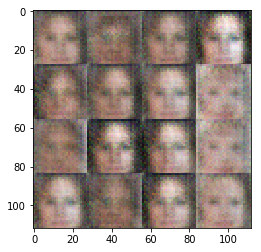

Epoch 0/1 Batch Step 410... Discriminator Loss: 1.6178... Generator Loss: 0.5659
Epoch 0/1 Batch Step 420... Discriminator Loss: 1.6496... Generator Loss: 0.5236
Epoch 0/1 Batch Step 430... Discriminator Loss: 1.5566... Generator Loss: 0.5673
Epoch 0/1 Batch Step 440... Discriminator Loss: 1.5869... Generator Loss: 0.6082
Epoch 0/1 Batch Step 450... Discriminator Loss: 1.5324... Generator Loss: 0.5981
Epoch 0/1 Batch Step 460... Discriminator Loss: 1.5743... Generator Loss: 0.5973
Epoch 0/1 Batch Step 470... Discriminator Loss: 1.5067... Generator Loss: 0.6089
Epoch 0/1 Batch Step 480... Discriminator Loss: 1.5354... Generator Loss: 0.6211
Epoch 0/1 Batch Step 490... Discriminator Loss: 1.5076... Generator Loss: 0.6548
Epoch 0/1 Batch Step 500... Discriminator Loss: 1.5837... Generator Loss: 0.6530


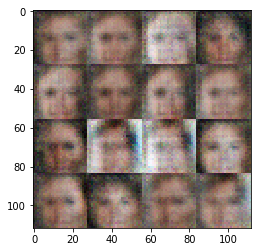

Epoch 0/1 Batch Step 510... Discriminator Loss: 1.4896... Generator Loss: 0.6671
Epoch 0/1 Batch Step 520... Discriminator Loss: 1.5121... Generator Loss: 0.6033
Epoch 0/1 Batch Step 530... Discriminator Loss: 1.5318... Generator Loss: 0.6497
Epoch 0/1 Batch Step 540... Discriminator Loss: 1.4972... Generator Loss: 0.6677
Epoch 0/1 Batch Step 550... Discriminator Loss: 1.5794... Generator Loss: 0.6425
Epoch 0/1 Batch Step 560... Discriminator Loss: 1.4876... Generator Loss: 0.6561
Epoch 0/1 Batch Step 570... Discriminator Loss: 1.5650... Generator Loss: 0.6026
Epoch 0/1 Batch Step 580... Discriminator Loss: 1.5126... Generator Loss: 0.6740
Epoch 0/1 Batch Step 590... Discriminator Loss: 1.5286... Generator Loss: 0.5789
Epoch 0/1 Batch Step 600... Discriminator Loss: 1.4973... Generator Loss: 0.6126


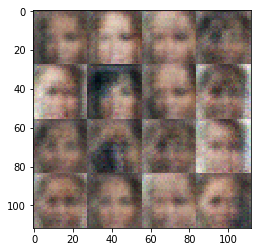

Epoch 0/1 Batch Step 610... Discriminator Loss: 1.4818... Generator Loss: 0.6555
Epoch 0/1 Batch Step 620... Discriminator Loss: 1.4600... Generator Loss: 0.6867
Epoch 0/1 Batch Step 630... Discriminator Loss: 1.4933... Generator Loss: 0.6026
Epoch 0/1 Batch Step 640... Discriminator Loss: 1.5839... Generator Loss: 0.5654
Epoch 0/1 Batch Step 650... Discriminator Loss: 1.5189... Generator Loss: 0.6128
Epoch 0/1 Batch Step 660... Discriminator Loss: 1.4502... Generator Loss: 0.6150
Epoch 0/1 Batch Step 670... Discriminator Loss: 1.5066... Generator Loss: 0.6210
Epoch 0/1 Batch Step 680... Discriminator Loss: 1.4828... Generator Loss: 0.6464
Epoch 0/1 Batch Step 690... Discriminator Loss: 1.4307... Generator Loss: 0.6365
Epoch 0/1 Batch Step 700... Discriminator Loss: 1.5210... Generator Loss: 0.6360


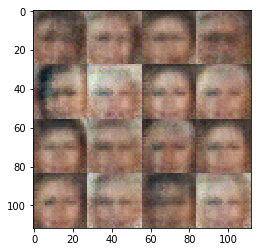

Epoch 0/1 Batch Step 710... Discriminator Loss: 1.4610... Generator Loss: 0.6232
Epoch 0/1 Batch Step 720... Discriminator Loss: 1.4906... Generator Loss: 0.6113
Epoch 0/1 Batch Step 730... Discriminator Loss: 1.5195... Generator Loss: 0.6324
Epoch 0/1 Batch Step 740... Discriminator Loss: 1.5004... Generator Loss: 0.6428
Epoch 0/1 Batch Step 750... Discriminator Loss: 1.4398... Generator Loss: 0.6684
Epoch 0/1 Batch Step 760... Discriminator Loss: 1.5442... Generator Loss: 0.6222
Epoch 0/1 Batch Step 770... Discriminator Loss: 1.4828... Generator Loss: 0.6161
Epoch 0/1 Batch Step 780... Discriminator Loss: 1.4610... Generator Loss: 0.6484
Epoch 0/1 Batch Step 790... Discriminator Loss: 1.4545... Generator Loss: 0.5857
Epoch 0/1 Batch Step 800... Discriminator Loss: 1.4513... Generator Loss: 0.6100


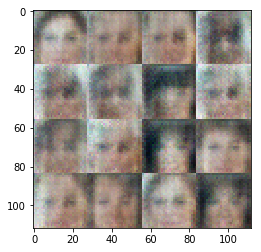

Epoch 0/1 Batch Step 810... Discriminator Loss: 1.4575... Generator Loss: 0.6881
Epoch 0/1 Batch Step 820... Discriminator Loss: 1.4385... Generator Loss: 0.6521
Epoch 0/1 Batch Step 830... Discriminator Loss: 1.4653... Generator Loss: 0.6636
Epoch 0/1 Batch Step 840... Discriminator Loss: 1.4525... Generator Loss: 0.6870
Epoch 0/1 Batch Step 850... Discriminator Loss: 1.4851... Generator Loss: 0.6281
Epoch 0/1 Batch Step 860... Discriminator Loss: 1.4433... Generator Loss: 0.6515
Epoch 0/1 Batch Step 870... Discriminator Loss: 1.5391... Generator Loss: 0.6223
Epoch 0/1 Batch Step 880... Discriminator Loss: 1.5044... Generator Loss: 0.6479
Epoch 0/1 Batch Step 890... Discriminator Loss: 1.4473... Generator Loss: 0.6408
Epoch 0/1 Batch Step 900... Discriminator Loss: 1.4891... Generator Loss: 0.6303


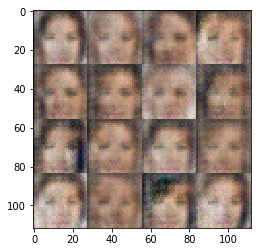

Epoch 0/1 Batch Step 910... Discriminator Loss: 1.4683... Generator Loss: 0.6202
Epoch 0/1 Batch Step 920... Discriminator Loss: 1.4462... Generator Loss: 0.6467
Epoch 0/1 Batch Step 930... Discriminator Loss: 1.4774... Generator Loss: 0.6754
Epoch 0/1 Batch Step 940... Discriminator Loss: 1.4507... Generator Loss: 0.6477
Epoch 0/1 Batch Step 950... Discriminator Loss: 1.4395... Generator Loss: 0.6830
Epoch 0/1 Batch Step 960... Discriminator Loss: 1.5099... Generator Loss: 0.6478
Epoch 0/1 Batch Step 970... Discriminator Loss: 1.4707... Generator Loss: 0.6736
Epoch 0/1 Batch Step 980... Discriminator Loss: 1.4924... Generator Loss: 0.6119
Epoch 0/1 Batch Step 990... Discriminator Loss: 1.4971... Generator Loss: 0.6798
Epoch 0/1 Batch Step 1000... Discriminator Loss: 1.4722... Generator Loss: 0.6532


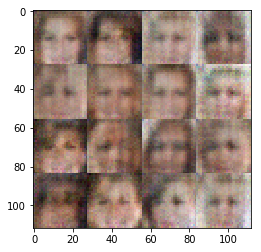

Epoch 0/1 Batch Step 1010... Discriminator Loss: 1.4784... Generator Loss: 0.6201
Epoch 0/1 Batch Step 1020... Discriminator Loss: 1.4727... Generator Loss: 0.6568
Epoch 0/1 Batch Step 1030... Discriminator Loss: 1.4471... Generator Loss: 0.6623
Epoch 0/1 Batch Step 1040... Discriminator Loss: 1.5185... Generator Loss: 0.6162
Epoch 0/1 Batch Step 1050... Discriminator Loss: 1.4614... Generator Loss: 0.6367
Epoch 0/1 Batch Step 1060... Discriminator Loss: 1.5486... Generator Loss: 0.5898
Epoch 0/1 Batch Step 1070... Discriminator Loss: 1.4205... Generator Loss: 0.6630
Epoch 0/1 Batch Step 1080... Discriminator Loss: 1.4605... Generator Loss: 0.6715
Epoch 0/1 Batch Step 1090... Discriminator Loss: 1.4308... Generator Loss: 0.6578
Epoch 0/1 Batch Step 1100... Discriminator Loss: 1.4854... Generator Loss: 0.6602


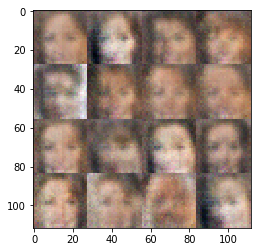

Epoch 0/1 Batch Step 1110... Discriminator Loss: 1.4268... Generator Loss: 0.6922
Epoch 0/1 Batch Step 1120... Discriminator Loss: 1.4437... Generator Loss: 0.6965
Epoch 0/1 Batch Step 1130... Discriminator Loss: 1.4279... Generator Loss: 0.6406
Epoch 0/1 Batch Step 1140... Discriminator Loss: 1.4996... Generator Loss: 0.6106
Epoch 0/1 Batch Step 1150... Discriminator Loss: 1.4757... Generator Loss: 0.6256
Epoch 0/1 Batch Step 1160... Discriminator Loss: 1.4917... Generator Loss: 0.6364
Epoch 0/1 Batch Step 1170... Discriminator Loss: 1.4565... Generator Loss: 0.6848
Epoch 0/1 Batch Step 1180... Discriminator Loss: 1.5040... Generator Loss: 0.5961
Epoch 0/1 Batch Step 1190... Discriminator Loss: 1.4351... Generator Loss: 0.6942
Epoch 0/1 Batch Step 1200... Discriminator Loss: 1.4419... Generator Loss: 0.6106


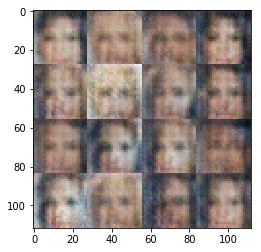

Epoch 0/1 Batch Step 1210... Discriminator Loss: 1.5288... Generator Loss: 0.6400
Epoch 0/1 Batch Step 1220... Discriminator Loss: 1.4634... Generator Loss: 0.6665
Epoch 0/1 Batch Step 1230... Discriminator Loss: 1.4803... Generator Loss: 0.6353
Epoch 0/1 Batch Step 1240... Discriminator Loss: 1.4356... Generator Loss: 0.6759
Epoch 0/1 Batch Step 1250... Discriminator Loss: 1.4448... Generator Loss: 0.6622
Epoch 0/1 Batch Step 1260... Discriminator Loss: 1.4633... Generator Loss: 0.6445
Epoch 0/1 Batch Step 1270... Discriminator Loss: 1.4101... Generator Loss: 0.6475
Epoch 0/1 Batch Step 1280... Discriminator Loss: 1.4817... Generator Loss: 0.6112
Epoch 0/1 Batch Step 1290... Discriminator Loss: 1.4688... Generator Loss: 0.6358
Epoch 0/1 Batch Step 1300... Discriminator Loss: 1.4418... Generator Loss: 0.6990


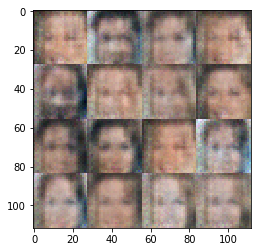

Epoch 0/1 Batch Step 1310... Discriminator Loss: 1.4638... Generator Loss: 0.6605
Epoch 0/1 Batch Step 1320... Discriminator Loss: 1.4322... Generator Loss: 0.6956
Epoch 0/1 Batch Step 1330... Discriminator Loss: 1.4518... Generator Loss: 0.6070
Epoch 0/1 Batch Step 1340... Discriminator Loss: 1.4690... Generator Loss: 0.5897
Epoch 0/1 Batch Step 1350... Discriminator Loss: 1.5410... Generator Loss: 0.6052
Epoch 0/1 Batch Step 1360... Discriminator Loss: 1.5120... Generator Loss: 0.6913
Epoch 0/1 Batch Step 1370... Discriminator Loss: 1.4424... Generator Loss: 0.6527
Epoch 0/1 Batch Step 1380... Discriminator Loss: 1.4582... Generator Loss: 0.6414
Epoch 0/1 Batch Step 1390... Discriminator Loss: 1.4478... Generator Loss: 0.6358
Epoch 0/1 Batch Step 1400... Discriminator Loss: 1.4493... Generator Loss: 0.6795


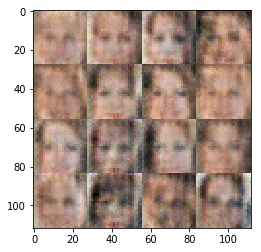

Epoch 0/1 Batch Step 1410... Discriminator Loss: 1.4757... Generator Loss: 0.6408
Epoch 0/1 Batch Step 1420... Discriminator Loss: 1.5022... Generator Loss: 0.6140
Epoch 0/1 Batch Step 1430... Discriminator Loss: 1.4748... Generator Loss: 0.6206
Epoch 0/1 Batch Step 1440... Discriminator Loss: 1.4409... Generator Loss: 0.6717
Epoch 0/1 Batch Step 1450... Discriminator Loss: 1.4361... Generator Loss: 0.6695
Epoch 0/1 Batch Step 1460... Discriminator Loss: 1.4348... Generator Loss: 0.7238
Epoch 0/1 Batch Step 1470... Discriminator Loss: 1.4657... Generator Loss: 0.6018
Epoch 0/1 Batch Step 1480... Discriminator Loss: 1.4728... Generator Loss: 0.6487
Epoch 0/1 Batch Step 1490... Discriminator Loss: 1.4296... Generator Loss: 0.6906
Epoch 0/1 Batch Step 1500... Discriminator Loss: 1.4307... Generator Loss: 0.6775


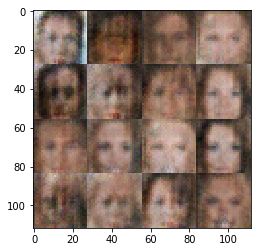

Epoch 0/1 Batch Step 1510... Discriminator Loss: 1.4216... Generator Loss: 0.6823
Epoch 0/1 Batch Step 1520... Discriminator Loss: 1.4138... Generator Loss: 0.6439
Epoch 0/1 Batch Step 1530... Discriminator Loss: 1.4621... Generator Loss: 0.6552
Epoch 0/1 Batch Step 1540... Discriminator Loss: 1.4703... Generator Loss: 0.6274
Epoch 0/1 Batch Step 1550... Discriminator Loss: 1.4377... Generator Loss: 0.6652
Epoch 0/1 Batch Step 1560... Discriminator Loss: 1.4749... Generator Loss: 0.6197
Epoch 0/1 Batch Step 1570... Discriminator Loss: 1.4367... Generator Loss: 0.6503
Epoch 0/1 Batch Step 1580... Discriminator Loss: 1.4718... Generator Loss: 0.6558
Epoch 0/1 Batch Step 1590... Discriminator Loss: 1.4328... Generator Loss: 0.6163
Epoch 0/1 Batch Step 1600... Discriminator Loss: 1.4100... Generator Loss: 0.6658


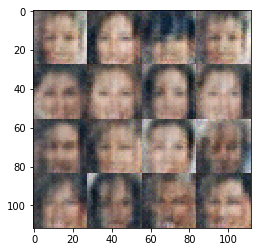

Epoch 0/1 Batch Step 1610... Discriminator Loss: 1.4228... Generator Loss: 0.6584
Epoch 0/1 Batch Step 1620... Discriminator Loss: 1.4449... Generator Loss: 0.6227
Epoch 0/1 Batch Step 1630... Discriminator Loss: 1.4763... Generator Loss: 0.6233
Epoch 0/1 Batch Step 1640... Discriminator Loss: 1.4173... Generator Loss: 0.6723
Epoch 0/1 Batch Step 1650... Discriminator Loss: 1.4551... Generator Loss: 0.6180
Epoch 0/1 Batch Step 1660... Discriminator Loss: 1.4293... Generator Loss: 0.6337
Epoch 0/1 Batch Step 1670... Discriminator Loss: 1.4408... Generator Loss: 0.6625
Epoch 0/1 Batch Step 1680... Discriminator Loss: 1.4152... Generator Loss: 0.6845
Epoch 0/1 Batch Step 1690... Discriminator Loss: 1.4229... Generator Loss: 0.6761
Epoch 0/1 Batch Step 1700... Discriminator Loss: 1.4561... Generator Loss: 0.6620


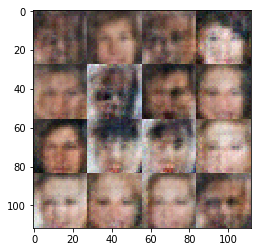

Epoch 0/1 Batch Step 1710... Discriminator Loss: 1.4210... Generator Loss: 0.6577
Epoch 0/1 Batch Step 1720... Discriminator Loss: 1.4417... Generator Loss: 0.6522
Epoch 0/1 Batch Step 1730... Discriminator Loss: 1.4265... Generator Loss: 0.6730
Epoch 0/1 Batch Step 1740... Discriminator Loss: 1.4417... Generator Loss: 0.6642
Epoch 0/1 Batch Step 1750... Discriminator Loss: 1.4391... Generator Loss: 0.6562
Epoch 0/1 Batch Step 1760... Discriminator Loss: 1.4407... Generator Loss: 0.6724
Epoch 0/1 Batch Step 1770... Discriminator Loss: 1.4646... Generator Loss: 0.6601
Epoch 0/1 Batch Step 1780... Discriminator Loss: 1.4571... Generator Loss: 0.6176
Epoch 0/1 Batch Step 1790... Discriminator Loss: 1.4411... Generator Loss: 0.6018
Epoch 0/1 Batch Step 1800... Discriminator Loss: 1.4416... Generator Loss: 0.6761


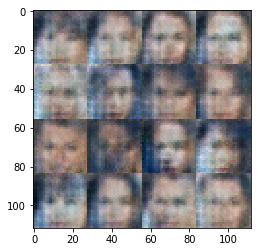

Epoch 0/1 Batch Step 1810... Discriminator Loss: 1.4629... Generator Loss: 0.6575
Epoch 0/1 Batch Step 1820... Discriminator Loss: 1.4734... Generator Loss: 0.6701
Epoch 0/1 Batch Step 1830... Discriminator Loss: 1.5015... Generator Loss: 0.6241
Epoch 0/1 Batch Step 1840... Discriminator Loss: 1.4852... Generator Loss: 0.6100
Epoch 0/1 Batch Step 1850... Discriminator Loss: 1.4321... Generator Loss: 0.6102
Epoch 0/1 Batch Step 1860... Discriminator Loss: 1.4311... Generator Loss: 0.6728
Epoch 0/1 Batch Step 1870... Discriminator Loss: 1.4809... Generator Loss: 0.6456
Epoch 0/1 Batch Step 1880... Discriminator Loss: 1.4662... Generator Loss: 0.6649
Epoch 0/1 Batch Step 1890... Discriminator Loss: 1.4574... Generator Loss: 0.6151
Epoch 0/1 Batch Step 1900... Discriminator Loss: 1.4211... Generator Loss: 0.6420


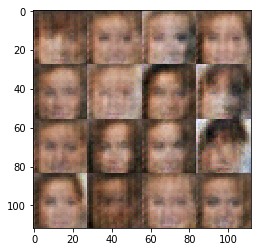

Epoch 0/1 Batch Step 1910... Discriminator Loss: 1.4542... Generator Loss: 0.6779
Epoch 0/1 Batch Step 1920... Discriminator Loss: 1.4521... Generator Loss: 0.6858
Epoch 0/1 Batch Step 1930... Discriminator Loss: 1.4314... Generator Loss: 0.6244
Epoch 0/1 Batch Step 1940... Discriminator Loss: 1.4626... Generator Loss: 0.6515
Epoch 0/1 Batch Step 1950... Discriminator Loss: 1.4168... Generator Loss: 0.6699
Epoch 0/1 Batch Step 1960... Discriminator Loss: 1.4436... Generator Loss: 0.6433
Epoch 0/1 Batch Step 1970... Discriminator Loss: 1.4473... Generator Loss: 0.6567
Epoch 0/1 Batch Step 1980... Discriminator Loss: 1.4305... Generator Loss: 0.6586
Epoch 0/1 Batch Step 1990... Discriminator Loss: 1.4419... Generator Loss: 0.6700
Epoch 0/1 Batch Step 2000... Discriminator Loss: 1.4188... Generator Loss: 0.7091


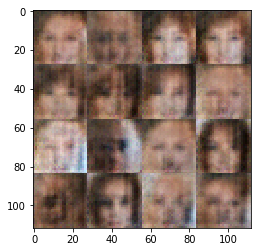

Epoch 0/1 Batch Step 2010... Discriminator Loss: 1.4371... Generator Loss: 0.6793
Epoch 0/1 Batch Step 2020... Discriminator Loss: 1.4278... Generator Loss: 0.6238
Epoch 0/1 Batch Step 2030... Discriminator Loss: 1.4108... Generator Loss: 0.6443
Epoch 0/1 Batch Step 2040... Discriminator Loss: 1.4432... Generator Loss: 0.6388
Epoch 0/1 Batch Step 2050... Discriminator Loss: 1.4232... Generator Loss: 0.6445
Epoch 0/1 Batch Step 2060... Discriminator Loss: 1.5090... Generator Loss: 0.6049
Epoch 0/1 Batch Step 2070... Discriminator Loss: 1.4468... Generator Loss: 0.6292
Epoch 0/1 Batch Step 2080... Discriminator Loss: 1.4667... Generator Loss: 0.6670
Epoch 0/1 Batch Step 2090... Discriminator Loss: 1.4500... Generator Loss: 0.6605
Epoch 0/1 Batch Step 2100... Discriminator Loss: 1.4426... Generator Loss: 0.6362


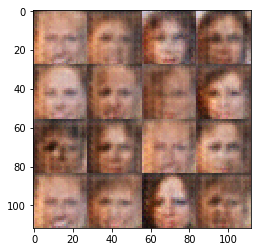

Epoch 0/1 Batch Step 2110... Discriminator Loss: 1.4419... Generator Loss: 0.6256
Epoch 0/1 Batch Step 2120... Discriminator Loss: 1.4331... Generator Loss: 0.6277
Epoch 0/1 Batch Step 2130... Discriminator Loss: 1.4447... Generator Loss: 0.6546
Epoch 0/1 Batch Step 2140... Discriminator Loss: 1.4330... Generator Loss: 0.6668
Epoch 0/1 Batch Step 2150... Discriminator Loss: 1.4615... Generator Loss: 0.6605
Epoch 0/1 Batch Step 2160... Discriminator Loss: 1.4265... Generator Loss: 0.6785
Epoch 0/1 Batch Step 2170... Discriminator Loss: 1.4313... Generator Loss: 0.7256
Epoch 0/1 Batch Step 2180... Discriminator Loss: 1.4175... Generator Loss: 0.6518
Epoch 0/1 Batch Step 2190... Discriminator Loss: 1.3957... Generator Loss: 0.7439
Epoch 0/1 Batch Step 2200... Discriminator Loss: 1.4061... Generator Loss: 0.6666


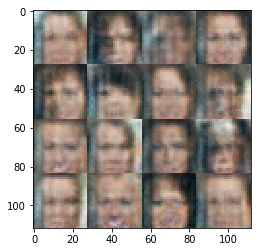

Epoch 0/1 Batch Step 2210... Discriminator Loss: 1.4300... Generator Loss: 0.6423
Epoch 0/1 Batch Step 2220... Discriminator Loss: 1.4276... Generator Loss: 0.7194
Epoch 0/1 Batch Step 2230... Discriminator Loss: 1.4375... Generator Loss: 0.6361
Epoch 0/1 Batch Step 2240... Discriminator Loss: 1.4402... Generator Loss: 0.7111
Epoch 0/1 Batch Step 2250... Discriminator Loss: 1.4528... Generator Loss: 0.6421
Epoch 0/1 Batch Step 2260... Discriminator Loss: 1.4467... Generator Loss: 0.6600
Epoch 0/1 Batch Step 2270... Discriminator Loss: 1.4141... Generator Loss: 0.6833
Epoch 0/1 Batch Step 2280... Discriminator Loss: 1.4440... Generator Loss: 0.6706
Epoch 0/1 Batch Step 2290... Discriminator Loss: 1.4218... Generator Loss: 0.6585
Epoch 0/1 Batch Step 2300... Discriminator Loss: 1.4735... Generator Loss: 0.6675


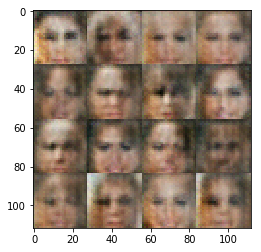

Epoch 0/1 Batch Step 2310... Discriminator Loss: 1.4598... Generator Loss: 0.6325
Epoch 0/1 Batch Step 2320... Discriminator Loss: 1.4168... Generator Loss: 0.6812
Epoch 0/1 Batch Step 2330... Discriminator Loss: 1.4310... Generator Loss: 0.6960
Epoch 0/1 Batch Step 2340... Discriminator Loss: 1.4485... Generator Loss: 0.6606
Epoch 0/1 Batch Step 2350... Discriminator Loss: 1.4393... Generator Loss: 0.6324
Epoch 0/1 Batch Step 2360... Discriminator Loss: 1.4311... Generator Loss: 0.6988
Epoch 0/1 Batch Step 2370... Discriminator Loss: 1.4438... Generator Loss: 0.6682
Epoch 0/1 Batch Step 2380... Discriminator Loss: 1.4165... Generator Loss: 0.6930
Epoch 0/1 Batch Step 2390... Discriminator Loss: 1.4354... Generator Loss: 0.6370
Epoch 0/1 Batch Step 2400... Discriminator Loss: 1.4580... Generator Loss: 0.6661


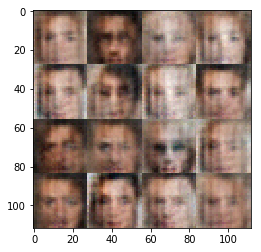

Epoch 0/1 Batch Step 2410... Discriminator Loss: 1.4959... Generator Loss: 0.6965
Epoch 0/1 Batch Step 2420... Discriminator Loss: 1.4213... Generator Loss: 0.6965
Epoch 0/1 Batch Step 2430... Discriminator Loss: 1.4529... Generator Loss: 0.6283
Epoch 0/1 Batch Step 2440... Discriminator Loss: 1.4604... Generator Loss: 0.6191
Epoch 0/1 Batch Step 2450... Discriminator Loss: 1.4827... Generator Loss: 0.6794
Epoch 0/1 Batch Step 2460... Discriminator Loss: 1.4907... Generator Loss: 0.6405
Epoch 0/1 Batch Step 2470... Discriminator Loss: 1.4536... Generator Loss: 0.6237
Epoch 0/1 Batch Step 2480... Discriminator Loss: 1.4533... Generator Loss: 0.6679
Epoch 0/1 Batch Step 2490... Discriminator Loss: 1.4805... Generator Loss: 0.6537
Epoch 0/1 Batch Step 2500... Discriminator Loss: 1.4576... Generator Loss: 0.6325


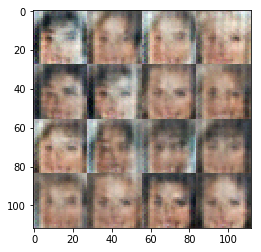

Epoch 0/1 Batch Step 2510... Discriminator Loss: 1.4230... Generator Loss: 0.6546
Epoch 0/1 Batch Step 2520... Discriminator Loss: 1.4281... Generator Loss: 0.6611
Epoch 0/1 Batch Step 2530... Discriminator Loss: 1.4383... Generator Loss: 0.6384
Epoch 0/1 Batch Step 2540... Discriminator Loss: 1.4507... Generator Loss: 0.6670
Epoch 0/1 Batch Step 2550... Discriminator Loss: 1.4973... Generator Loss: 0.6403
Epoch 0/1 Batch Step 2560... Discriminator Loss: 1.4908... Generator Loss: 0.6446
Epoch 0/1 Batch Step 2570... Discriminator Loss: 1.4415... Generator Loss: 0.6495
Epoch 0/1 Batch Step 2580... Discriminator Loss: 1.4357... Generator Loss: 0.6995
Epoch 0/1 Batch Step 2590... Discriminator Loss: 1.4302... Generator Loss: 0.6555
Epoch 0/1 Batch Step 2600... Discriminator Loss: 1.4281... Generator Loss: 0.6306


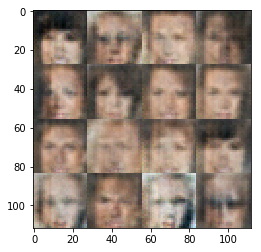

Epoch 0/1 Batch Step 2610... Discriminator Loss: 1.4937... Generator Loss: 0.6121
Epoch 0/1 Batch Step 2620... Discriminator Loss: 1.4024... Generator Loss: 0.7379
Epoch 0/1 Batch Step 2630... Discriminator Loss: 1.4369... Generator Loss: 0.6597
Epoch 0/1 Batch Step 2640... Discriminator Loss: 1.4263... Generator Loss: 0.6718
Epoch 0/1 Batch Step 2650... Discriminator Loss: 1.4222... Generator Loss: 0.6856
Epoch 0/1 Batch Step 2660... Discriminator Loss: 1.4219... Generator Loss: 0.6256
Epoch 0/1 Batch Step 2670... Discriminator Loss: 1.4649... Generator Loss: 0.6867
Epoch 0/1 Batch Step 2680... Discriminator Loss: 1.5118... Generator Loss: 0.5816
Epoch 0/1 Batch Step 2690... Discriminator Loss: 1.4169... Generator Loss: 0.6781
Epoch 0/1 Batch Step 2700... Discriminator Loss: 1.4229... Generator Loss: 0.6521


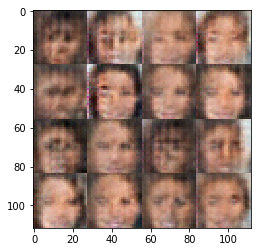

Epoch 0/1 Batch Step 2710... Discriminator Loss: 1.4276... Generator Loss: 0.6345
Epoch 0/1 Batch Step 2720... Discriminator Loss: 1.4467... Generator Loss: 0.6839
Epoch 0/1 Batch Step 2730... Discriminator Loss: 1.4229... Generator Loss: 0.7207
Epoch 0/1 Batch Step 2740... Discriminator Loss: 1.4743... Generator Loss: 0.5913
Epoch 0/1 Batch Step 2750... Discriminator Loss: 1.4539... Generator Loss: 0.6683
Epoch 0/1 Batch Step 2760... Discriminator Loss: 1.4193... Generator Loss: 0.6562
Epoch 0/1 Batch Step 2770... Discriminator Loss: 1.4485... Generator Loss: 0.6796
Epoch 0/1 Batch Step 2780... Discriminator Loss: 1.4555... Generator Loss: 0.6375
Epoch 0/1 Batch Step 2790... Discriminator Loss: 1.4306... Generator Loss: 0.6615
Epoch 0/1 Batch Step 2800... Discriminator Loss: 1.4059... Generator Loss: 0.6290


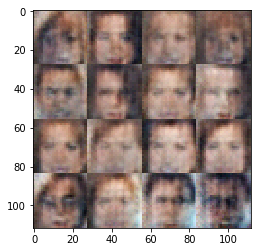

Epoch 0/1 Batch Step 2810... Discriminator Loss: 1.4683... Generator Loss: 0.6001
Epoch 0/1 Batch Step 2820... Discriminator Loss: 1.4322... Generator Loss: 0.6647
Epoch 0/1 Batch Step 2830... Discriminator Loss: 1.4231... Generator Loss: 0.6762
Epoch 0/1 Batch Step 2840... Discriminator Loss: 1.4108... Generator Loss: 0.6468
Epoch 0/1 Batch Step 2850... Discriminator Loss: 1.4429... Generator Loss: 0.6498
Epoch 0/1 Batch Step 2860... Discriminator Loss: 1.4253... Generator Loss: 0.6423
Epoch 0/1 Batch Step 2870... Discriminator Loss: 1.4529... Generator Loss: 0.6527
Epoch 0/1 Batch Step 2880... Discriminator Loss: 1.4263... Generator Loss: 0.7025
Epoch 0/1 Batch Step 2890... Discriminator Loss: 1.4577... Generator Loss: 0.6266
Epoch 0/1 Batch Step 2900... Discriminator Loss: 1.4498... Generator Loss: 0.6416


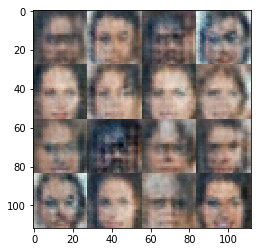

Epoch 0/1 Batch Step 2910... Discriminator Loss: 1.4665... Generator Loss: 0.6874
Epoch 0/1 Batch Step 2920... Discriminator Loss: 1.4500... Generator Loss: 0.6413
Epoch 0/1 Batch Step 2930... Discriminator Loss: 1.4650... Generator Loss: 0.6719
Epoch 0/1 Batch Step 2940... Discriminator Loss: 1.4386... Generator Loss: 0.6620
Epoch 0/1 Batch Step 2950... Discriminator Loss: 1.4329... Generator Loss: 0.6843
Epoch 0/1 Batch Step 2960... Discriminator Loss: 1.4340... Generator Loss: 0.6361
Epoch 0/1 Batch Step 2970... Discriminator Loss: 1.4370... Generator Loss: 0.6675
Epoch 0/1 Batch Step 2980... Discriminator Loss: 1.4521... Generator Loss: 0.7134
Epoch 0/1 Batch Step 2990... Discriminator Loss: 1.4425... Generator Loss: 0.6702
Epoch 0/1 Batch Step 3000... Discriminator Loss: 1.4633... Generator Loss: 0.6545


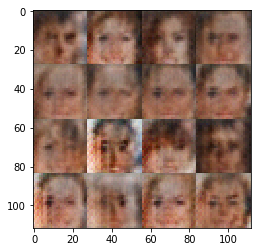

Epoch 0/1 Batch Step 3010... Discriminator Loss: 1.4171... Generator Loss: 0.6735
Epoch 0/1 Batch Step 3020... Discriminator Loss: 1.4014... Generator Loss: 0.6425
Epoch 0/1 Batch Step 3030... Discriminator Loss: 1.4764... Generator Loss: 0.6592
Epoch 0/1 Batch Step 3040... Discriminator Loss: 1.4431... Generator Loss: 0.6410
Epoch 0/1 Batch Step 3050... Discriminator Loss: 1.4273... Generator Loss: 0.6616
Epoch 0/1 Batch Step 3060... Discriminator Loss: 1.4250... Generator Loss: 0.6849
Epoch 0/1 Batch Step 3070... Discriminator Loss: 1.4430... Generator Loss: 0.6637
Epoch 0/1 Batch Step 3080... Discriminator Loss: 1.4555... Generator Loss: 0.6502
Epoch 0/1 Batch Step 3090... Discriminator Loss: 1.4442... Generator Loss: 0.7153
Epoch 0/1 Batch Step 3100... Discriminator Loss: 1.4580... Generator Loss: 0.6735


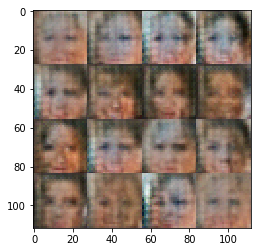

Epoch 0/1 Batch Step 3110... Discriminator Loss: 1.4708... Generator Loss: 0.6727
Epoch 0/1 Batch Step 3120... Discriminator Loss: 1.4577... Generator Loss: 0.6556
Epoch 0/1 Batch Step 3130... Discriminator Loss: 1.4228... Generator Loss: 0.6653
Epoch 0/1 Batch Step 3140... Discriminator Loss: 1.4724... Generator Loss: 0.6266
Epoch 0/1 Batch Step 3150... Discriminator Loss: 1.4262... Generator Loss: 0.7184
Epoch 0/1 Batch Step 3160... Discriminator Loss: 1.4275... Generator Loss: 0.6848
Done Training!


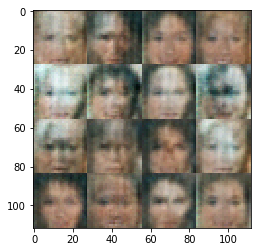

In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.